In [205]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from typing import List

In [206]:
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere
rng = np.random.default_rng(2020)

In [307]:
class LIFNeurons:
    def __init__(
        self,
        n: int, # number of neurons
        t_max: float = 150e-3, # end timestamp
        dt: float = 1e-3, # time increment
        tau: float = 20e-3, # time scale
        el: float = -60e-3, # initial potential
        vr: float = -70e-3, # resting potential
        vth: float = -50e-3, # threshold potential
        r: float = 100e6, # membrane resistance
        i_mean = 25e-11, # average input current
        t_ref = 1e-2, # refactory period (ms)
        rng = random.default_rng(2024),
        with_spiking: bool = True,
        with_refactory: bool = False,
    ):
        # Initial constants 
        self.n = n
        self.t_max = t_max
        self.dt = dt
        self.tau = tau
        self.el = el
        self.vr = vr
        self.vth = vth
        self.r = r
        self.i_mean = i_mean
        self.t_ref = t_ref
        self.rng = rng
        self.with_spiking = with_spiking
        self.with_refactory = with_refactory
        
        self.times = np.arange(0.0, t_max, dt)
        self.neuron_potentials = []
    
    def run(self):
        neurons = []
        for i in range(self.n):
            synaptic_inputs = self.synaptic_input()
            potentials = self.membrane_potentials(synaptic_inputs, self.with_spiking)
            neurons.append(potentials)
        self.neuron_potentials = np.asarray(neurons)
    
    def mean_potentials(self) -> np.ndarray:
        return np.mean(self.neuron_potentials, axis = 0)

    def stdv_potentials(self) -> np.ndarray:
        return np.std(self.neuron_potentials, axis = 0)
    
    def spike_index(self) -> np.ndarray:
        return self.neuron_potentials > self.vth
    
    def spike_times(self, neuron_idx: int) -> np.ndarray:
        spike_index = self.spike_index()
        neuron_spikes = spike_index[neuron_idx]
        return self.times[neuron_spikes]
    
    def spike_frequency(self) -> np.ndarray:
        spike_mean = np.zeros_like(self.times)
        for i in range(self.n):
            spike_index = self.spike_index()
            for j, did_spike in enumerate(spike_index[i]):
                if did_spike:
                    spike_mean[j] += 1
        spike_mean = spike_mean / self.n
        return spike_mean
    
    def synaptic_input(self, is_random: bool = True) -> np.ndarray:
        if is_random:
            random_values = self.rng.uniform(-1, 1, size = self.times.shape)
            i_t_arr = self.i_mean * (1 + (0.1 * np.sqrt(self.t_max / self.dt)) * random_values)
            return i_t_arr
        else:
            i_t_arr = i_mean * (1 + np.sin((2 * np.pi * self.times) / 0.01))
            return i_t_arr

    def membrane_potentials(
        self,
        synaptic_inputs: np.ndarray,
        enable_spiking: bool = False,
    ) -> np.ndarray:
        potentials = []
        t = 0.0
        step_idx = 0
        current_potential = self.el
        last_spike = None
        while t < self.t_max:
            # Get current state of the neuron
            current_synaptic_input = synaptic_inputs[step_idx]

            # Calculate the next potential using a Euler step
            time_factor = self.dt / tau

            if enable_spiking and (current_potential > self.vth):
                next_potential = self.vr
                last_spike = t
            elif self.with_refactory and (last_spike is not None) and (t < last_spike + self.t_ref):
                next_potential = self.vr
            else:
                next_potential = current_potential + time_factor * (self.el - current_potential + self.r * current_synaptic_input)

            # Increment state
            t += self.dt
            step_idx += 1

            # Persist
            potentials.append(next_potential)
            current_potential = next_potential

        return np.asarray(potentials)

    def potentials_at_t(self, t: float) -> np.ndarray:
        potential_index = max(int(t / self.dt) - 1, 0) # Don't go below 0 index
        return self.neuron_potentials[:, potential_index]

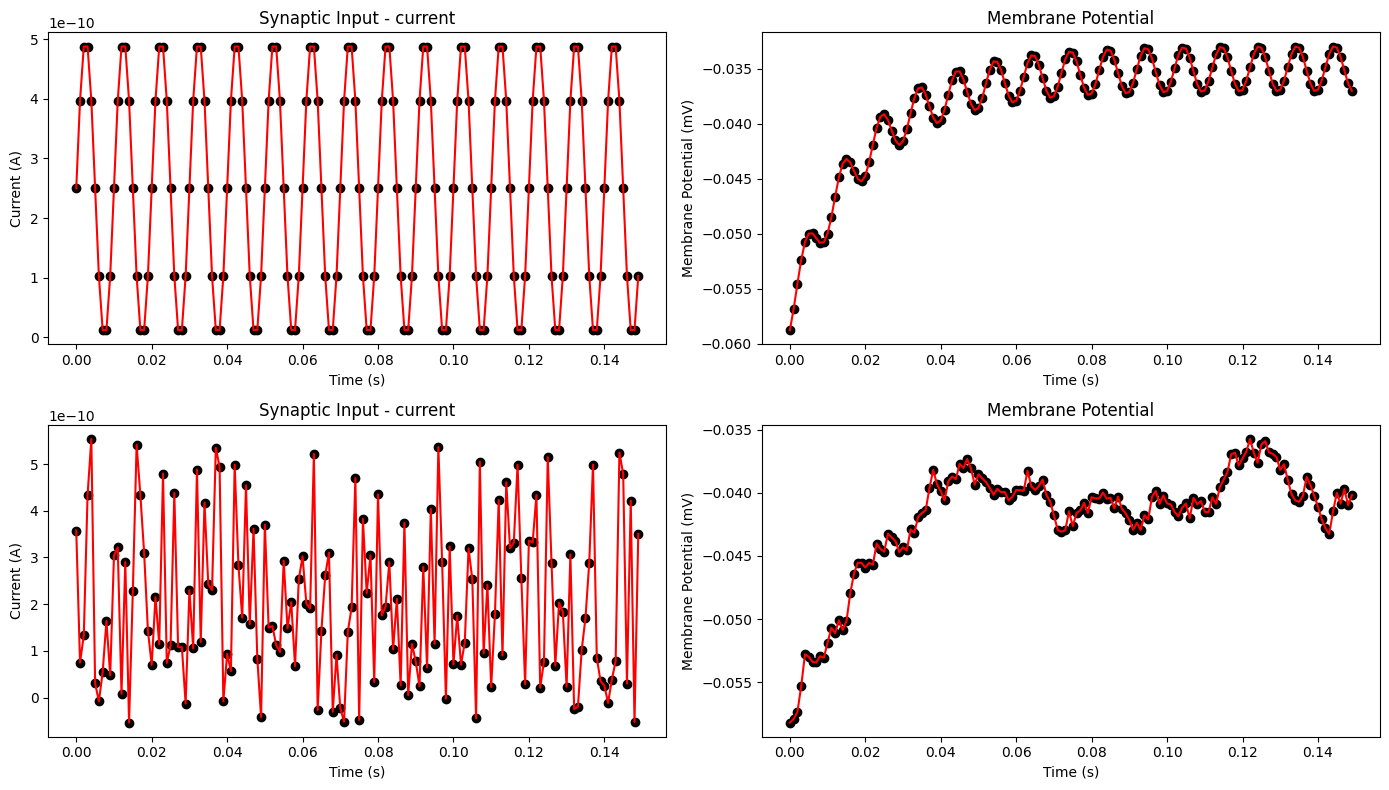

In [304]:
from matplotlib.axes import Axes

def plot_synaptic_inputs(ax: Axes, inputs, times: np.ndarray):
    ax.set_title('Synaptic Input - current')
    ax.plot(times, inputs, 'ko')
    ax.plot(times, inputs, 'red')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (A)')

def plot_n_experiments(
    ax: Axes,
    all_potentials: np.ndarray,
    times: np.ndarray,
    mean_potentials: np.ndarray,
    standard_deviation: np.ndarray,
):
    ax.set_title("N experiments")
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Membrane Potential (mV)")
    ax.plot(times, mean_potentials, color='black', alpha=1.0)
    ax.plot(times, mean_potentials + standard_deviation, color='blue')
    ax.plot(times, mean_potentials - standard_deviation, color='blue')
    for neuron_potentials in all_potentials:
        ax.plot(times, neuron_potentials, alpha = 0.1)
    plt.show()

def plot_membrane_potential(ax: Axes, result: np.ndarray, times: np.ndarray):
    ax.set_title('Membrane Potential')
    ax.plot(times, result, 'ko')
    ax.plot(times, result, 'red')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Membrane Potential (mV)')

def plot_histograms(ax: Axes,samples: List[np.ndarray]):
    ax.set_title("Membrane Potential Histogram)")
    for i in range(len(samples)):
        potentials = samples[i]
        _, bin_edges = np.histogram(potentials, bins='auto')
        ax.hist(potentials, bins=bin_edges, color = random_color())

def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

lif = LIFNeurons(1)
# Plot non-random synaptic inputs
syn_inputs = lif.synaptic_input(is_random=False)
potentials = lif.membrane_potentials(syn_inputs)
plot_synaptic_inputs(ax[0][0], syn_inputs, lif.times)
plot_membrane_potential(ax[0][1], potentials, lif.times)

# Plot random synpatic inputs and potentials
syn_inputs = lif.synaptic_input(is_random=True)
potentials = lif.membrane_potentials(syn_inputs)
plot_synaptic_inputs(ax[1][0], syn_inputs, lif.times)
plot_membrane_potential(ax[1][1], potentials, lif.times)

plt.tight_layout()
plt.show()

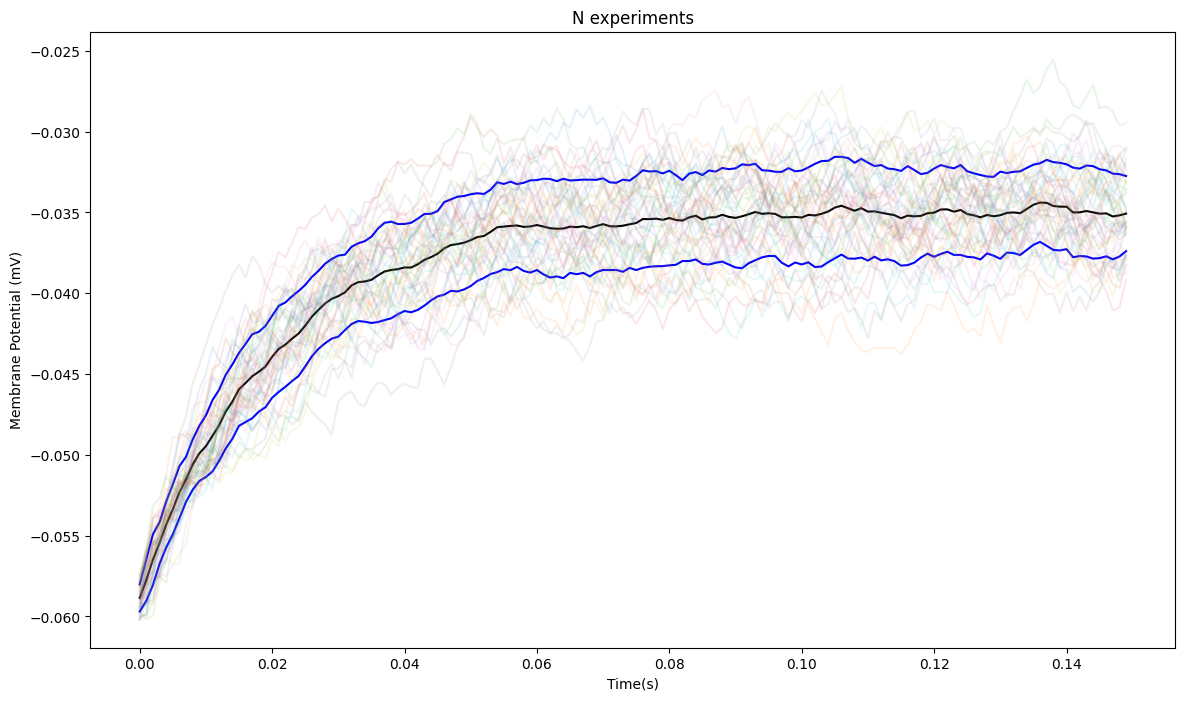

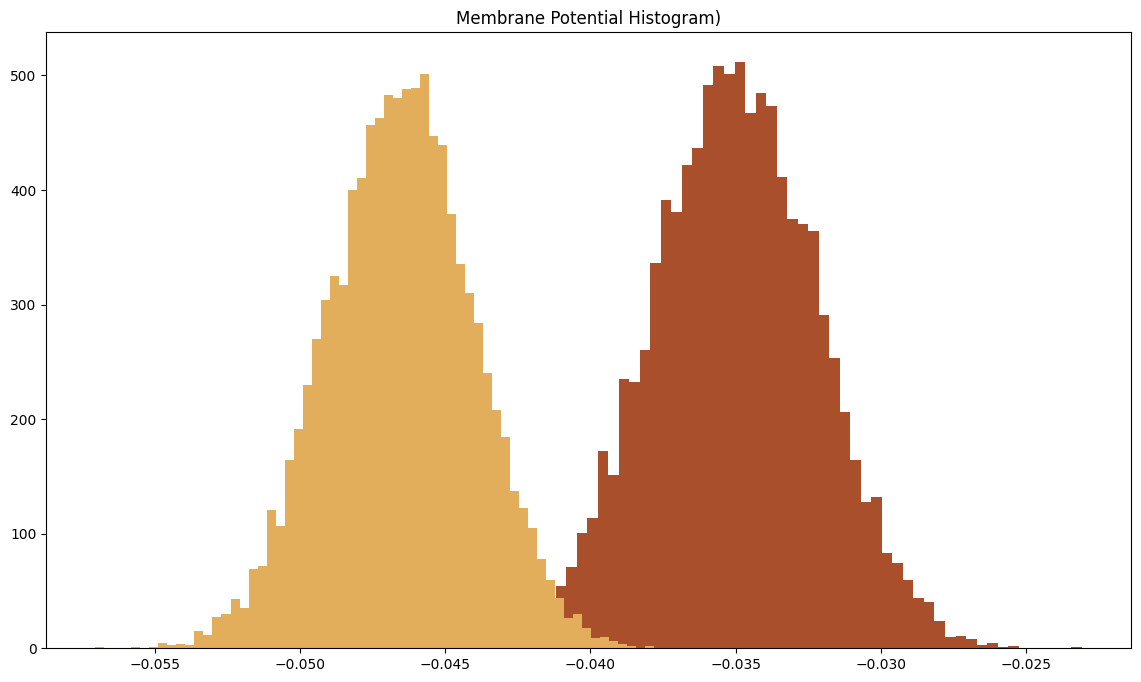

In [305]:
plt.figure(figsize=(14, 8))
curr_ax = plt.gca()
lif = LIFNeurons(50, with_spiking=False)
lif.run()
plot_n_experiments(curr_ax, lif.neuron_potentials, lif.times, lif.mean_potentials(), lif.stdv_potentials())
plt.show()

plt.figure(figsize=(14, 8))
curr_ax = plt.gca()
lif = LIFNeurons(10000, with_spiking=False)
lif.run()

potentials_at_t_max = lif.potentials_at_t(lif.t_max)
potentials_at_t_max_by_10 = lif.potentials_at_t(lif.t_max / 10)

# Plot PDF (histogram) of potentials at these times
plot_histograms(curr_ax, [potentials_at_t_max, potentials_at_t_max_by_10])

plt.show()

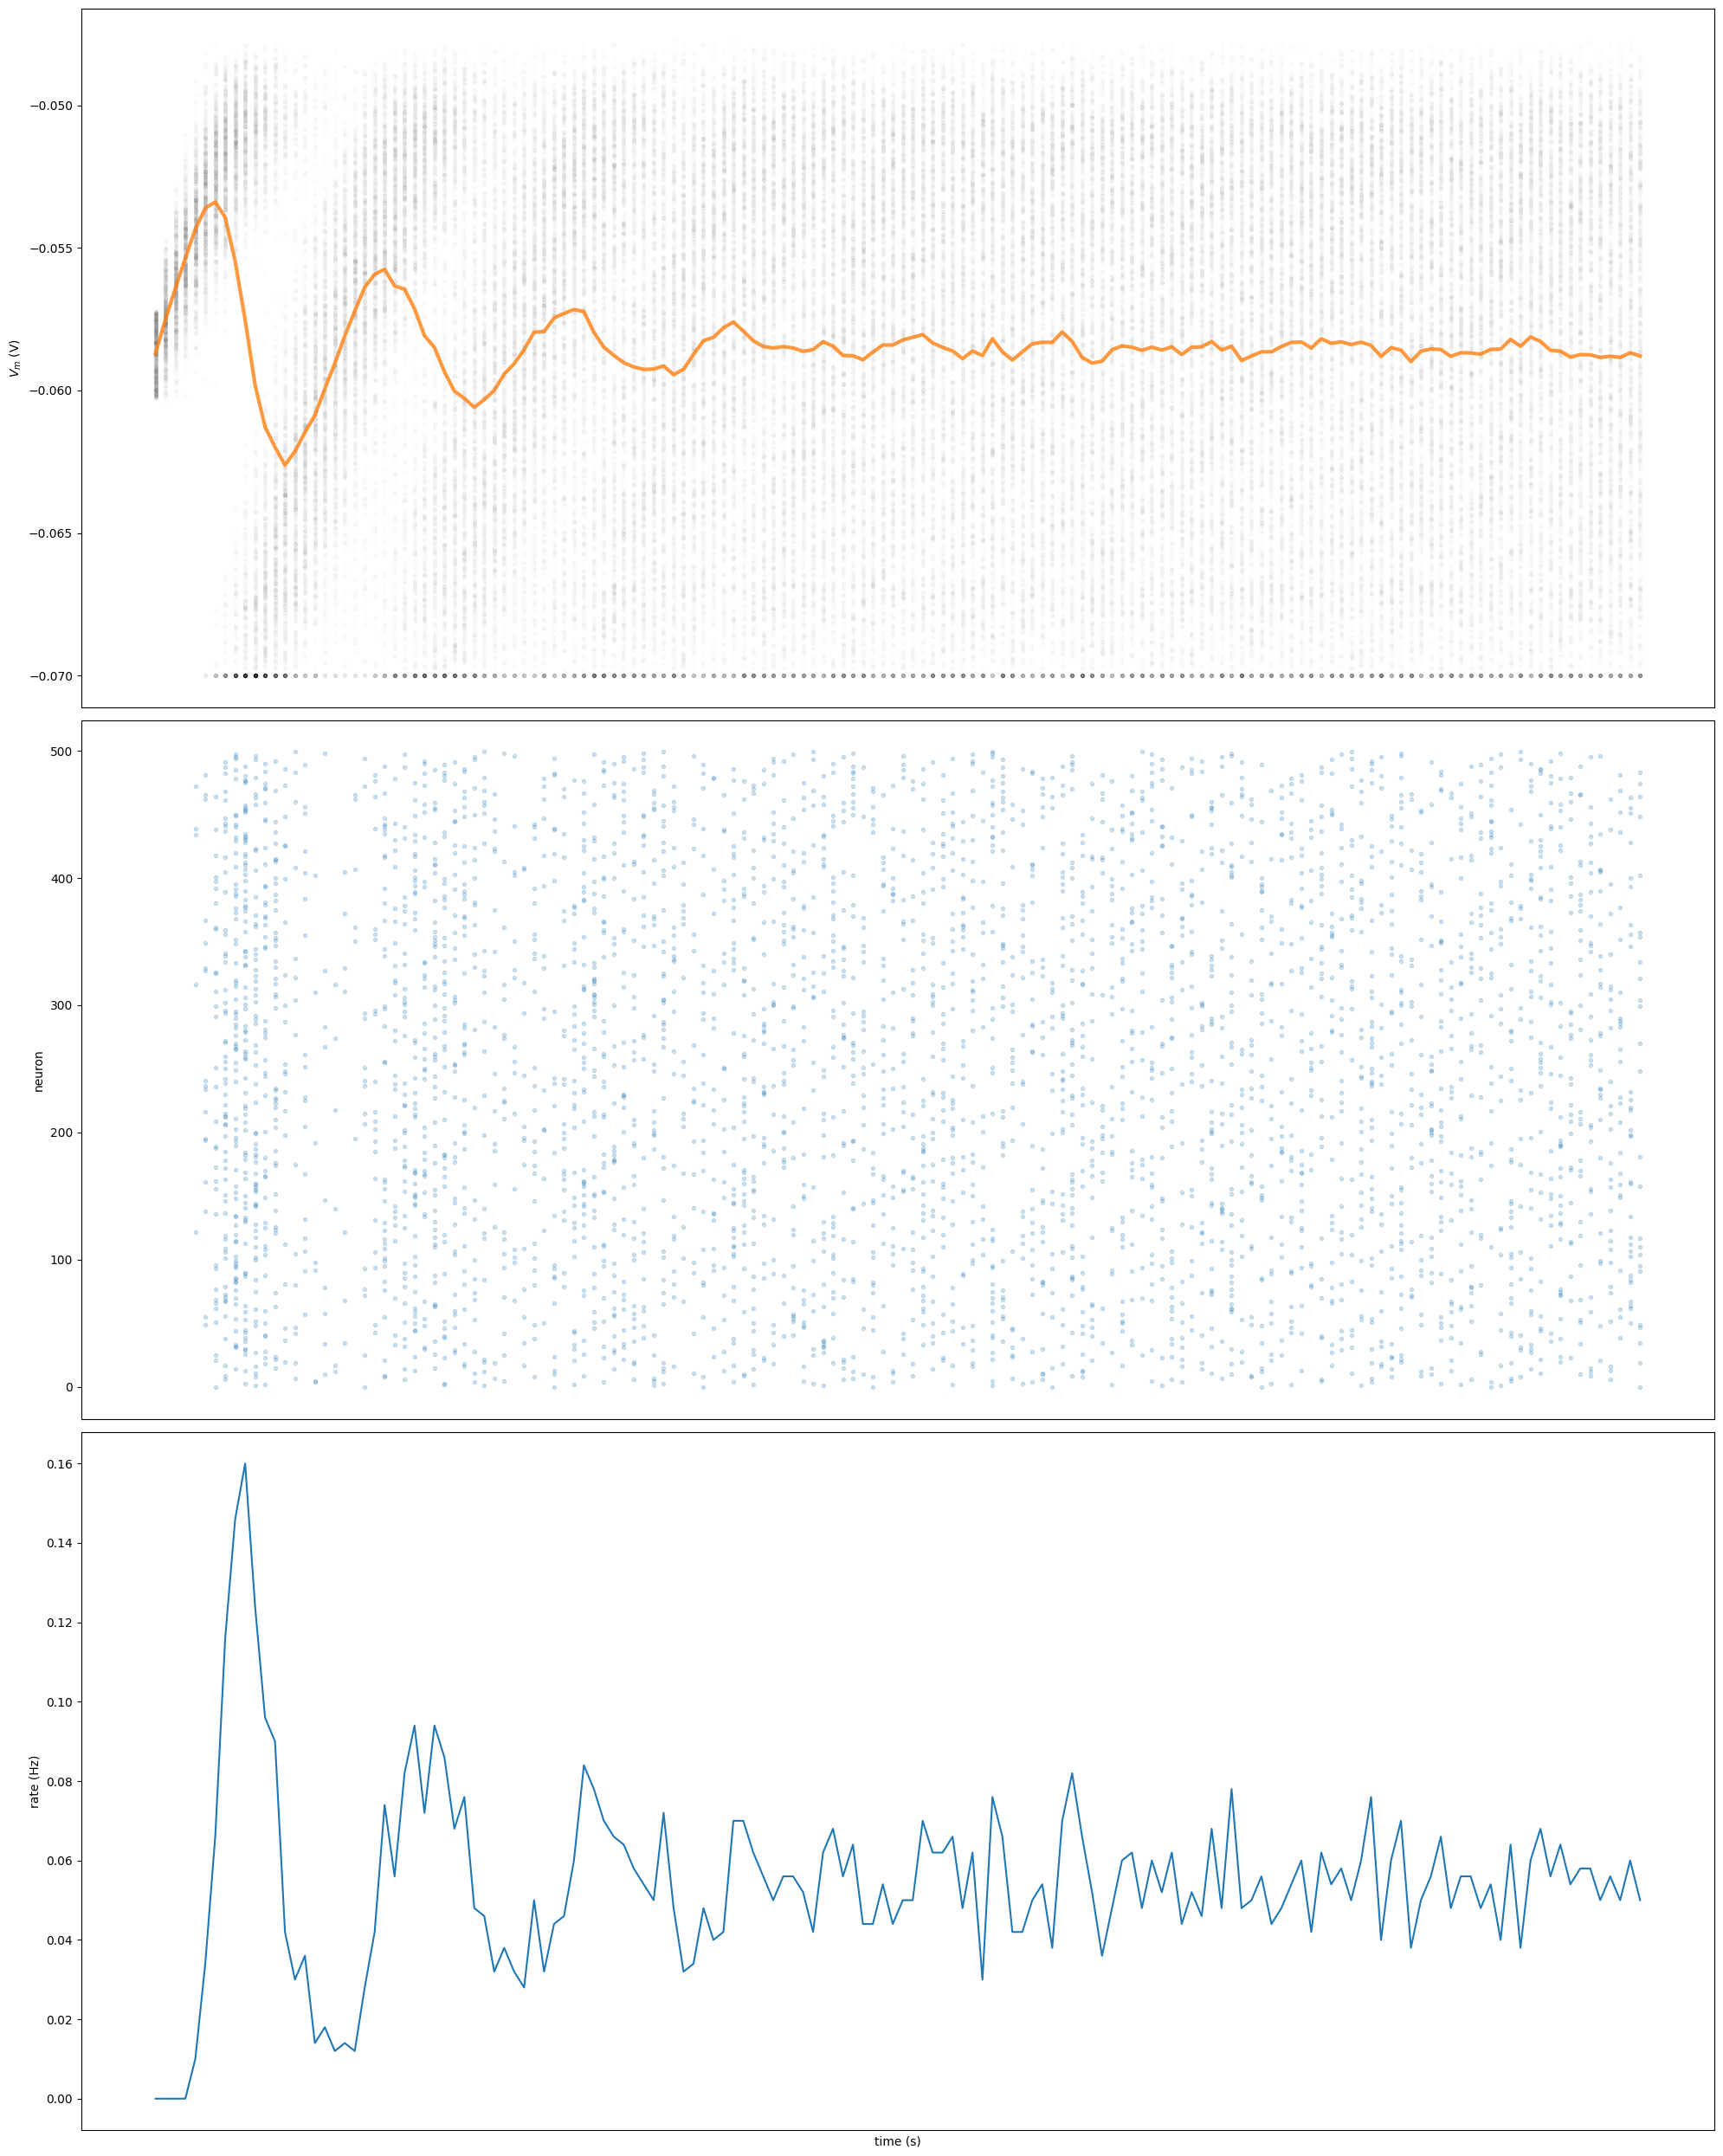

In [306]:
def plot_all(lif: LIFNeurons):
    plt.figure(figsize=(20, 25))

    ax1 = plt.subplot(3, 1, 1)
    for i in range(lif.n):
        plt.scatter(lif.times, lif.neuron_potentials[i], color="k", marker=".", alpha=0.01)
    plt.plot(lif.times, lif.mean_potentials(), 'C1', alpha=0.8, linewidth=3)
    plt.xticks([])
    plt.ylabel(r'$V_m$ (V)')

    plt.subplot(3, 1, 2, sharex=ax1)
    for i in range(lif.n):
        spike_times = lif.spike_times(i)
        plt.scatter(spike_times, np.ones_like(spike_times) * i, color = "C0", marker=".", alpha = 0.2)
    plt.xticks([])
    plt.ylabel('neuron')
    
    # if raster is not None:
    #     plt.subplot(3, 1, 2)
    #     spikes_mean = np.mean(raster, axis=0)
    #     plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')
    # 

    spike_frequency = lif.spike_frequency()
    plt.subplot(3, 1, 3, sharex=ax1)
    plt.plot(lif.times, spike_frequency)
    plt.xlabel('time (s)')
    plt.ylabel('rate (Hz)')

    plt.tight_layout()
    plt.show()
    
lif = LIFNeurons(500, with_spiking=True)
lif.run()
plot_all(lif) 


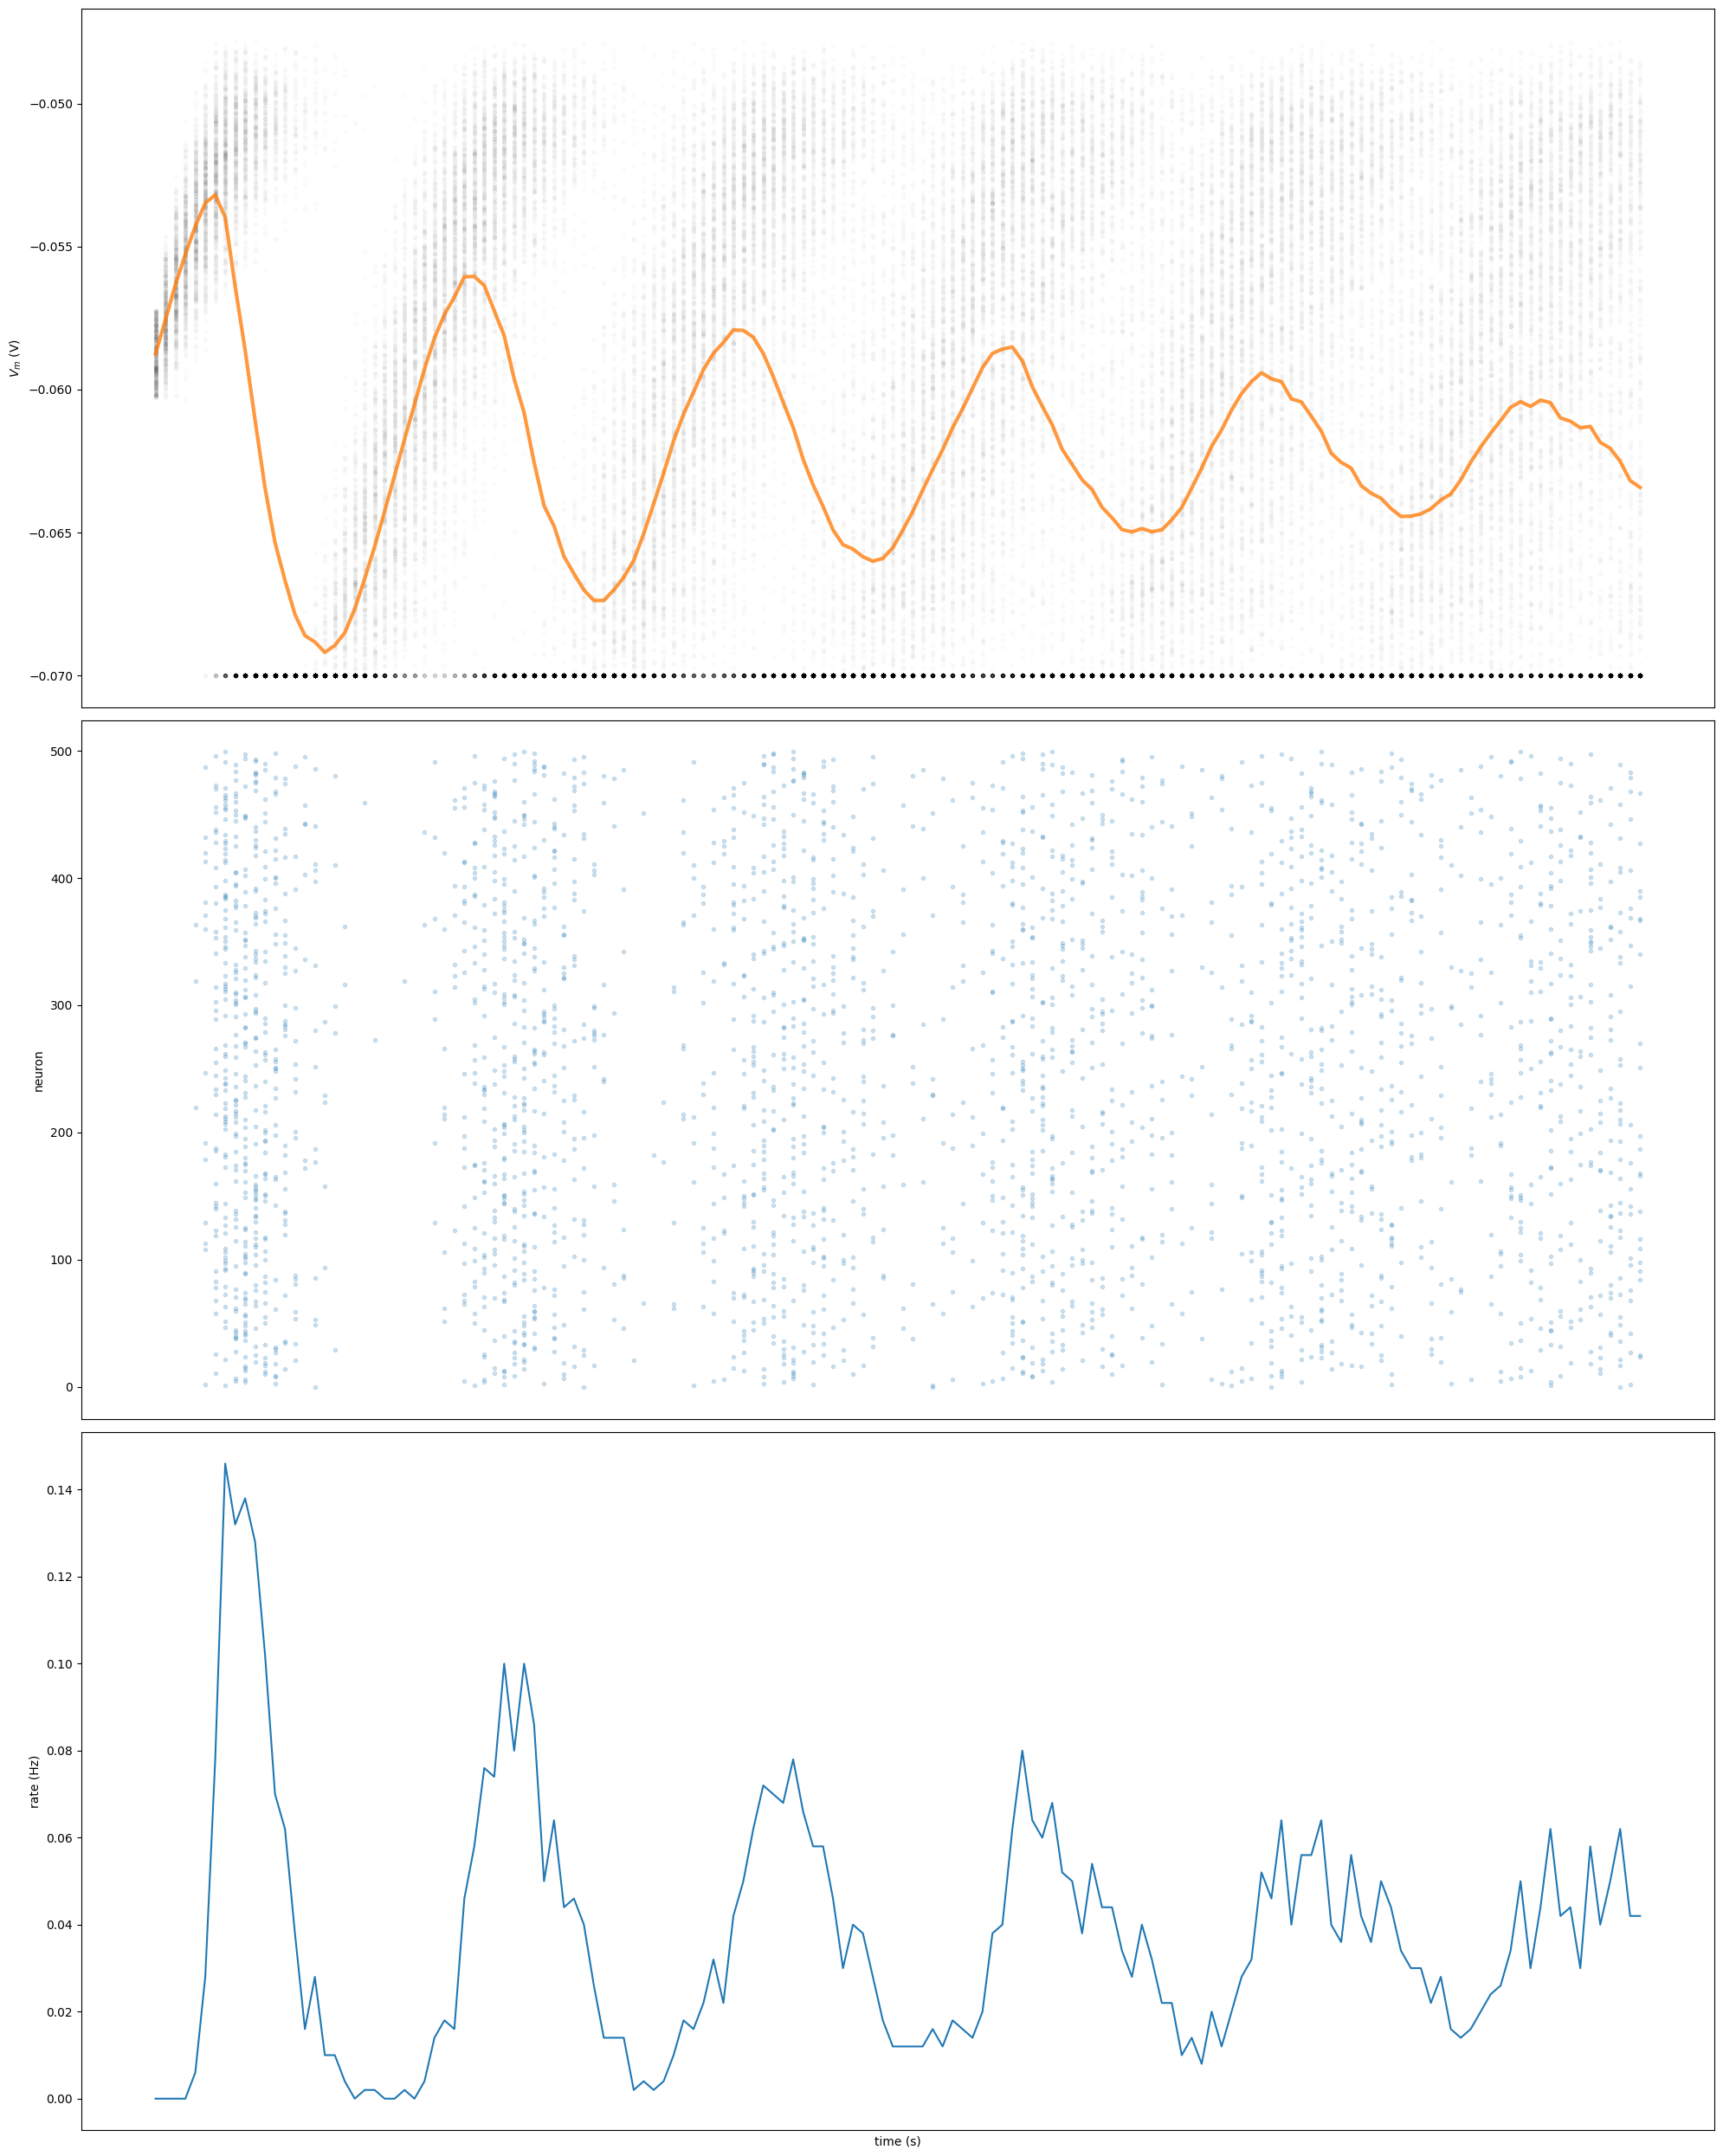

In [308]:
lif = LIFNeurons(500, with_spiking=True, with_refactory=True)
lif.run()
plot_all(lif) 